# Behavior metrics: comparison between AR=1.3 clusters

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict
from pp_utils.file_handling import df_main_loader
from pp_utils.trial_processor import TrialProcessor
from pp_utils import utils, utils_plot

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

In [7]:
stat_path = Path("../stat")

### Load main dataframe

In [8]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [9]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info

In [10]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [11]:
df_summary["TRIAL_TO_INCLUDE"] = df_main["TRIAL_TO_INCLUDE"]

In [12]:
df_summary["TCCT"] = df_main["LEFT"] + df_main["RIGHT"]

## Sort clusters

### 7clusters

In [13]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [14]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [15]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


## Cluster names and colors

### M spheroid - 7 clusters

In [16]:
color_cluster_7 = {
    "TC_straight": "#0077BB",  # blue
    "TC_curved1": "black",
    "TC_curved2": "#EE6677",  # pink
    "CT_straight": "#762A83",  # purple
    "CT_curved1": "black",
    "CT_curved2": "#1B7837",  # green
}
color_cluster_seq_7 = list(color_cluster_7.values())

In [17]:
CLUSTER_STR_7 = ["Straight", "Curved-1", "Curved-2", "Straight", "Curved-1", "Curved-2"]

## Plot each panel separately first

In [18]:
def plot_vio_jitter(ax, var_wanted):

    for seq in range(6):
        df_wanted = df_cluster_clean_7[seq]
        color = color_cluster_seq_7[seq]

        idx_cross = df_wanted["time_buzz_onset_clean"] < df_wanted["time_decision"]

        vals_dot = df_wanted[var_wanted][~idx_cross].values
        vals_cross = df_wanted[var_wanted][idx_cross].values

        vals = np.hstack((vals_dot, vals_cross))
        vals = vals[~np.isnan(vals)]

        utils_plot.plot_vio(ax, vals, seq, color=color, qbar_alpha=0.3, widths=0.6)
        utils_plot.plot_jitter(ax, seq, vals_dot, color=color, marker=".", markersize=3)
        utils_plot.plot_jitter(ax, seq, vals_cross, color=color, marker="x", markersize=5)

### Time decision to touch

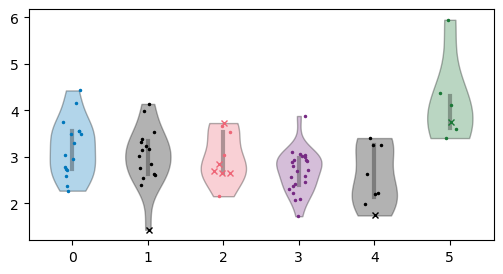

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plot_vio_jitter(ax, var_wanted="time_decision2touch")
plt.show()

### Decision distance to sphere

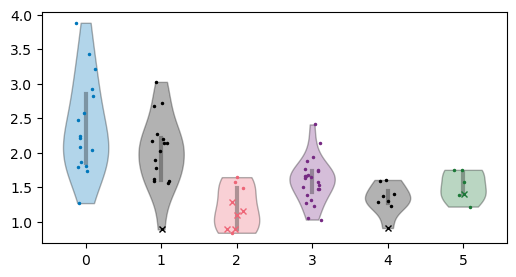

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plot_vio_jitter(ax, var_wanted="range_decision_tar")
plt.show()

### Decision distance to spheroid

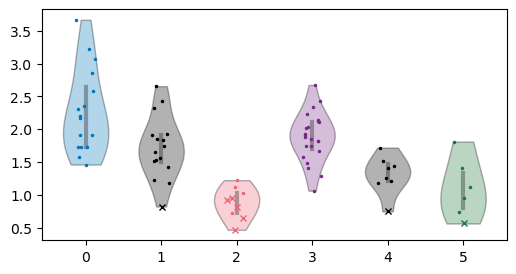

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plot_vio_jitter(ax, var_wanted="range_decision_clu")
plt.show()

### Time buzz onset to touch

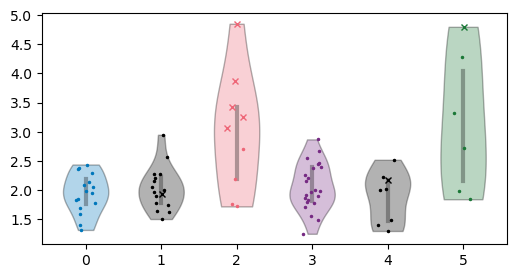

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plot_vio_jitter(ax, var_wanted="time_buzz2touch")
plt.show()

### Distance to first buzzed object

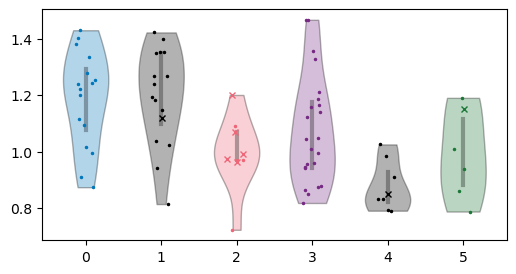

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plot_vio_jitter(ax, var_wanted="range_buzz_onset_closest")
plt.show()

### Scans on sphere / spheroid

In [24]:
# Scan parameters
scan_bins = np.arange(0, 13) - 0.5
scan_x = (scan_bins[:-1] + scan_bins[1:])/2
scan_bar_width = 0.25

In [25]:
# Vertical shift for CT clusters
vert_shift = 0.6

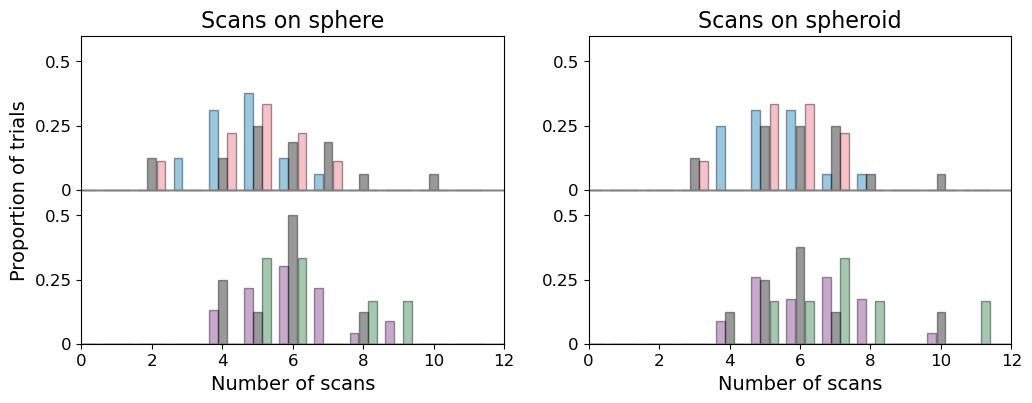

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax_scan0 = ax[0]
ax_scan1 = ax[1]

for seq in range(6):
    ta_ch0, _ = np.histogram(df_cluster_clean_7[seq]["scan_ch0"]-1, bins=scan_bins, density=True)
    ta_ch1, _ = np.histogram(df_cluster_clean_7[seq]["scan_ch1"], bins=scan_bins, density=True)

    # Horiztonal bar shift
    if np.mod(seq, 3) == 0:
        shift = -scan_bar_width-0.01 # if straight shift bar leftward
    elif np.mod(seq, 3) == 1:
        shift = 0  # if curved 1 do not shift bar
    else:
        shift = scan_bar_width+0.01  # if curved 2 shift bar rightward
    
    bottom = vert_shift if seq <= 2 else 0

    ax_scan0.bar(
        x=scan_x + shift, height=ta_ch0, width=scan_bar_width, bottom=bottom,
        alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq]
    )
    ax_scan1.bar(
        x=scan_x + shift, height=ta_ch1, width=scan_bar_width, bottom=bottom,
        alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq]
    )
    
    ax_scan0.axhline(bottom, color="grey", lw=1)
    ax_scan1.axhline(bottom, color="grey", lw=1)

for axx in [ax_scan0, ax_scan1]:
    axx.set_xlim(0, 12)
    axx.set_xticks(np.arange(0, 13, 2))
    axx.set_xticklabels(np.arange(0, 13, 2), fontsize=12)
    axx.set_yticks(np.array([0, 0.25, 0.5, vert_shift, vert_shift+0.25, vert_shift+0.5]))
    yticklabels = [0, 0.25, 0.5, 0, 0.25, 0.5]
    axx.set_yticklabels(yticklabels, fontsize=12)
    axx.set_ylim(0, vert_shift*2)
    axx.set_xlabel("Number of scans", fontsize=14)

ax_scan0.set_ylabel("Proportion of trials", fontsize=14)
ax_scan0.set_title("Scans on sphere", fontsize=16)
ax_scan1.set_title("Scans on spheroid", fontsize=16)

plt.show()

## Functions to annotate p values

In [27]:
stat_path

PosixPath('../stat')

In [28]:
utils_plot.STAT_FILENAME_MIDDLE

{'A': 'A_decision_time',
 'B1': 'B1_decision_range_target',
 'B2': 'B2_decision_range_clutter',
 'C': 'C_buzz_time',
 'D': 'D_buzz_range',
 'E': 'E_scan_ch0',
 'F': 'F_scan_ch1'}

In [29]:
fname_position = f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['A']}_position_contrast.csv"
fname_cluster = f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['A']}_cluster_contrast.csv"

In [30]:
# Sanity check
assert (stat_path / fname_position).exists()
assert (stat_path / fname_cluster).exists()

In [31]:
df_stat_position = pd.read_csv(stat_path / fname_position)

In [32]:
# p-value for position contrast
p_val_position = utils_plot.get_p_val_position(df_stat_position)
p_val_position

0.559848976780807

In [33]:
df_stat_cluster = pd.read_csv(stat_path / fname_cluster)

In [34]:
df_stat_cluster

,position,contrast,estimate,SE,df,lower.CL,upper.CL,t.ratio,p.value
0,TC,Straight - (Curved-1),0.189091,0.213263,72,-0.435314,0.813495,0.886656,0.948538
1,TC,Straight - (Curved-2),0.207926,0.251333,72,-0.527941,0.943794,0.827295,0.961492
2,TC,(Curved-1) - (Curved-2),0.018836,0.251333,72,-0.717032,0.754703,0.074943,1.000000
3,CT,Straight - (Curved-1),0.098066,0.247589,72,-0.626842,0.822974,0.396083,0.998690
4,CT,Straight - (Curved-2),-1.505401,0.276515,72,-2.315000,-0.695801,-5.444183,0.000010
5,CT,(Curved-1) - (Curved-2),-1.603466,0.325764,72,-2.557260,-0.649673,-4.922169,0.000075


In [35]:
utils_plot.STAT_POSITION

['TC', 'TC', 'TC', 'CT', 'CT', 'CT']

In [36]:
# for lm
utils_plot.STAT_CONTRAST_DIFF

['Straight - (Curved-1)',
 'Straight - (Curved-2)',
 '(Curved-1) - (Curved-2)',
 'Straight - (Curved-1)',
 'Straight - (Curved-2)',
 '(Curved-1) - (Curved-2)']

In [37]:
# for glm
utils_plot.STAT_CONTRAST_RATIO

['Straight / (Curved-1)',
 'Straight / (Curved-2)',
 '(Curved-1) / (Curved-2)',
 'Straight / (Curved-1)',
 'Straight / (Curved-2)',
 '(Curved-1) / (Curved-2)']

In [38]:
fname_position_scan = f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['E']}_position_contrast.csv"
fname_cluster_scan = f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['E']}_cluster_contrast.csv"

In [39]:
df_stat_position_scan = pd.read_csv(stat_path / fname_position_scan)
df_stat_cluster_scan = pd.read_csv(stat_path / fname_cluster_scan)

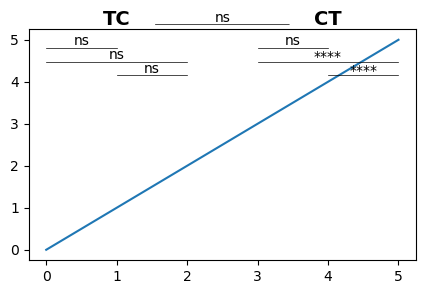

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

ax.plot(np.arange(6))

utils_plot.annotate_p_val_cluster(ax=ax, df_stat=df_stat_cluster)
utils_plot.annotate_p_val_position(ax=ax, df_stat=df_stat_position)
utils_plot.add_TCCT_text(ax=ax)

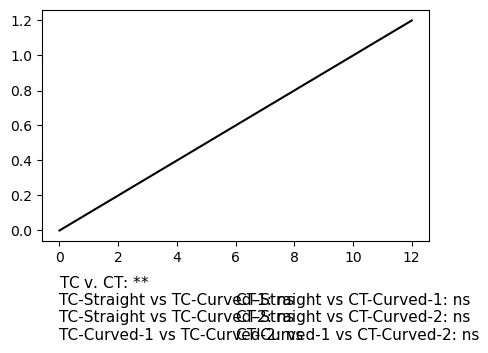

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

ax.plot([0, 12], [0, 1.2], color="k")
utils_plot.annotate_p_val_scan(ax, df_stat_position_scan, df_stat_cluster_scan, ratio=True)

plt.show()

## Put everything into a figure

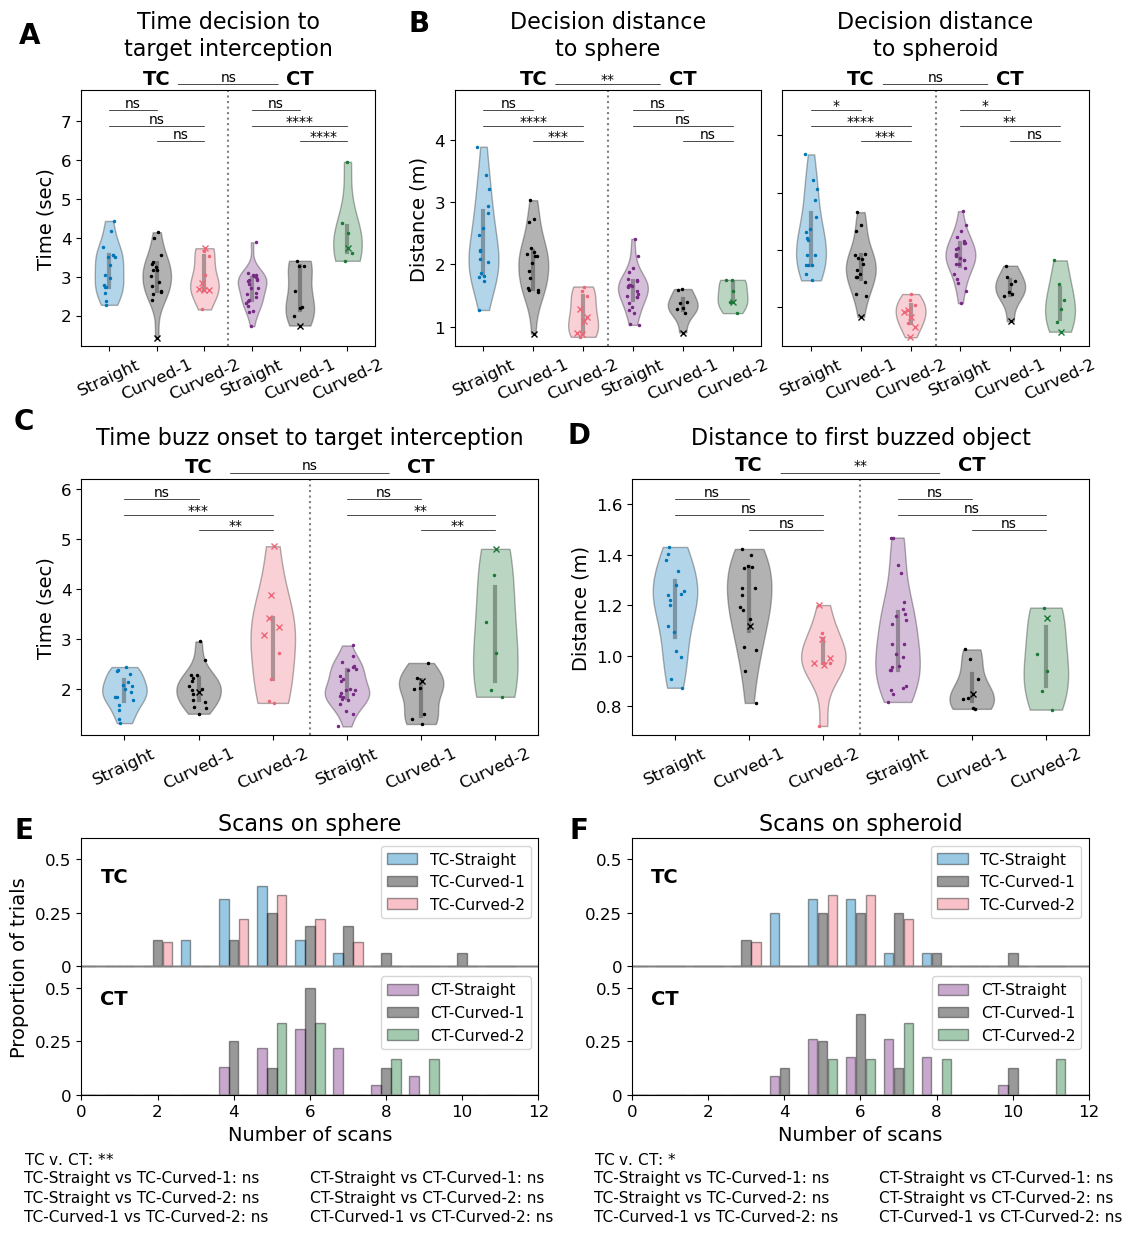

In [42]:
fig = plt.figure(figsize=(13, 13), facecolor="w")#, constrained_layout=True)

gs = fig.add_gridspec(3, 12)

plt.subplots_adjust(hspace=0.45)



# Decision: Time to touch
# ===================================
ax_decision_time = fig.add_subplot(gs[0, :4])
# ===================================
plot_vio_jitter(
    ax=ax_decision_time,
    var_wanted="time_decision2touch",
)
ax_decision_time.set_title("Time decision to\ntarget interception\n", fontsize=16)
ax_decision_time.set_ylabel("Time (sec)", fontsize=14)

# add vertical space
ylim = ax_decision_time.get_ylim()
ax_decision_time.set_ylim(ylim[0], 7.8)

# annotation
df_stat_position = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['A']}_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['A']}_cluster_contrast.csv")
utils_plot.annotate_p_val_position(ax_decision_time, df_stat_position)
utils_plot.annotate_p_val_cluster(ax_decision_time, df_stat_cluster)
utils_plot.add_TCCT_text(ax_decision_time)



# Decision: distance to target
# ===================================
ax_decision_dist_t = fig.add_subplot(gs[0, 4:8])
# ===================================
plot_vio_jitter(
    ax=ax_decision_dist_t,
    var_wanted="range_decision_tar",
)
ax_decision_dist_t.set_title("Decision distance\nto sphere\n", fontsize=16)
ax_decision_dist_t.set_ylabel("Distance (m)", fontsize=14)

# add vertical space
ylim = ax_decision_dist_t.get_ylim()
ax_decision_dist_t.set_ylim(ylim[0], 4.8)

# annotation
df_stat_position = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['B1']}_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['B1']}_cluster_contrast.csv")
utils_plot.annotate_p_val_position(ax_decision_dist_t, df_stat_position)
utils_plot.annotate_p_val_cluster(ax_decision_dist_t, df_stat_cluster)
utils_plot.add_TCCT_text(ax_decision_dist_t)



# Decision: distance to clutter
# ===================================
ax_decision_dist_c = fig.add_subplot(gs[0, 8:])
# ===================================
plot_vio_jitter(
    ax=ax_decision_dist_c,
    var_wanted="range_decision_clu",
)
ax_decision_dist_c.set_title("Decision distance\nto spheroid\n", fontsize=16)
ax_decision_dist_c.set_yticklabels("")

# add vertical space
ylim = ax_decision_dist_c.get_ylim()
ax_decision_dist_c.set_ylim(ylim[0], 4.8)

# annotation
df_stat_position = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['B2']}_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['B2']}_cluster_contrast.csv")
utils_plot.annotate_p_val_position(ax_decision_dist_c, df_stat_position)
utils_plot.annotate_p_val_cluster(ax_decision_dist_c, df_stat_cluster)
utils_plot.add_TCCT_text(ax_decision_dist_c)




# Buzz onset: Time to touch
# ===================================
ax_buzz_time = fig.add_subplot(gs[1, :6])
# ===================================
plot_vio_jitter(
    ax=ax_buzz_time,
    var_wanted="time_buzz2touch",
)
ax_buzz_time.set_title("Time buzz onset to target interception\n", fontsize=16)
ax_buzz_time.set_ylabel("Time (sec)", fontsize=14)

# add vertical space
ylim = ax_buzz_time.get_ylim()
ax_buzz_time.set_ylim(ylim[0], 6.2)

# annotation
df_stat_position = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['C']}_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['C']}_cluster_contrast.csv")
utils_plot.annotate_p_val_position(ax_buzz_time, df_stat_position)
utils_plot.annotate_p_val_cluster(ax_buzz_time, df_stat_cluster)
utils_plot.add_TCCT_text(ax_buzz_time)



# Buzz onset: Distance to the first buzzed object
# ===================================
ax_buzz_dist = fig.add_subplot(gs[1, 6:])
# ===================================
plot_vio_jitter(
    ax=ax_buzz_dist,
    var_wanted="range_buzz_onset_closest",
)
ax_buzz_dist.set_title("Distance to first buzzed object\n", fontsize=16)
ax_buzz_dist.set_ylabel("Distance (m)", fontsize=14)

# add vertical space
ylim = ax_buzz_dist.get_ylim()
ax_buzz_dist.set_ylim(ylim[0], 1.7)

# annotation
df_stat_position = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['D']}_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['D']}_cluster_contrast.csv")
utils_plot.annotate_p_val_position(ax_buzz_dist, df_stat_position)
utils_plot.annotate_p_val_cluster(ax_buzz_dist, df_stat_cluster)
utils_plot.add_TCCT_text(ax_buzz_dist)





# Add xaxis label and middle dashed line
for axx in [
    ax_decision_time, ax_decision_dist_t, ax_decision_dist_c,
]:
    axx.set_xticks(np.arange(6))
    axx.set_xticklabels(CLUSTER_STR_7, fontsize=12, rotation=25)
    axx.tick_params(axis='y', labelsize=12)
    axx.axvline(2.5, color="grey", ls=":")

for axx in [
    ax_buzz_time, ax_buzz_dist
]:
    axx.set_xticks(np.arange(6))
    axx.set_xticklabels(CLUSTER_STR_7, fontsize=12, rotation=25)
    axx.tick_params(axis='y', labelsize=12)
    axx.axvline(2.5, color="grey", ls=":")
    
    
# Adjust x-position of decision dist to T and C panels
axx = ax_decision_time
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0, axx_pos.y0, axx_pos.width*0.9, axx_pos.height
])
axx = ax_decision_dist_t
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0+axx_pos.width*0.1, axx_pos.y0, axx_pos.width*0.94, axx_pos.height
])
axx = ax_decision_dist_c
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0+axx_pos.width*0.06, axx_pos.y0, axx_pos.width*0.94, axx_pos.height
])


# Adjust width of buzz panels
axx = ax_buzz_time
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0, axx_pos.y0, axx_pos.width*0.92, axx_pos.height
])
axx = ax_buzz_dist
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0+axx_pos.width*0.08, axx_pos.y0, axx_pos.width*0.92, axx_pos.height
])

    

# Number of scans
# ===================================
ax_scan0 = fig.add_subplot(gs[2, :6])
ax_scan1 = fig.add_subplot(gs[2, 6:])
# ===================================

for seq in range(6):
    ta_ch0, _ = np.histogram(df_cluster_clean_7[seq]["scan_ch0"]-1, bins=scan_bins, density=True)
    ta_ch1, _ = np.histogram(df_cluster_clean_7[seq]["scan_ch1"], bins=scan_bins, density=True)

    # Horiztonal bar shift
    if np.mod(seq, 3) == 0:
        shift = -scan_bar_width-0.01 # if straight shift bar leftward
    elif np.mod(seq, 3) == 1:
        shift = 0  # if curved 1 do not shift bar
    else:
        shift = scan_bar_width+0.01  # if curved 2 shift bar rightward
    
    bottom = vert_shift if seq <= 2 else 0

    ax_scan0.bar(
        x=scan_x + shift, height=ta_ch0, width=scan_bar_width, bottom=bottom,
        alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq]
    )
    ax_scan1.bar(
        x=scan_x + shift, height=ta_ch1, width=scan_bar_width, bottom=bottom,
        alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq]
    )
    
    ax_scan0.axhline(bottom, color="grey", lw=1)
    ax_scan1.axhline(bottom, color="grey", lw=1)

# annotation
df_stat_position = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['E']}_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['E']}_cluster_contrast.csv")
utils_plot.annotate_p_val_scan(
    ax_scan0, df_stat_position, df_stat_cluster, ratio=True,
    horz_text_left=-1.5, horz_text_right=6, vert_text_gap=0.09
)

df_stat_position = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['F']}_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / f"AR13_{utils_plot.STAT_FILENAME_MIDDLE['F']}_cluster_contrast.csv")
utils_plot.annotate_p_val_scan(
    ax_scan1, df_stat_position, df_stat_cluster, ratio=True,
    horz_text_left=-1, horz_text_right=6.5, vert_text_gap=0.09
)


    
for axx in [ax_scan0, ax_scan1]:
    axx.set_xlim(0, 12)
    axx.set_xticks(np.arange(0, 13, 2))
    axx.set_xticklabels(np.arange(0, 13, 2), fontsize=12)
    axx.set_yticks(np.array([0, 0.25, 0.5, vert_shift, vert_shift+0.25, vert_shift+0.5]))
    yticklabels = [0, 0.25, 0.5, 0, 0.25, 0.5]
    axx.set_yticklabels(yticklabels, fontsize=12)
    axx.set_ylim(0, vert_shift*2)
    axx.set_xlabel("Number of scans", fontsize=14)

ax_scan0.set_ylabel("Proportion of trials", fontsize=14)
ax_scan0.set_title("Scans on sphere", fontsize=16)
ax_scan1.set_title("Scans on spheroid", fontsize=16)


# Adjust width of scan panels
axx = ax_scan0
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0, axx_pos.y0, axx_pos.width*0.92, axx_pos.height
])
axx = ax_scan1
axx_pos = axx.get_position()
axx.set_position([
    axx_pos.x0+axx_pos.width*0.08, axx_pos.y0, axx_pos.width*0.92, axx_pos.height
])


# Adjust y-position of 2nd and 3rd rows
for axx in [ax_decision_time, ax_decision_dist_t, ax_decision_dist_c]:
    axx_pos = axx.get_position()
    axx.set_position([
        axx_pos.x0, axx_pos.y0-0.017, axx_pos.width, axx_pos.height  # 0.015
    ])
for axx in [ax_buzz_time, ax_buzz_dist]:
    axx_pos = axx.get_position()
    axx.set_position([
        axx_pos.x0, axx_pos.y0-0.03, axx_pos.width, axx_pos.height  # 0.012
    ])
for axx in [ax_scan0, ax_scan1]:
    axx_pos = axx.get_position()
    axx.set_position([
        axx_pos.x0, axx_pos.y0-0.02, axx_pos.width, axx_pos.height  # 0.012
    ])

    
# Add scan histogram legend
ax_scan0_pos = ax_scan0.get_position()
ax_scan1_pos = ax_scan1.get_position()

for ax_pos in [ax_scan0_pos, ax_scan1_pos]:
    ax_clu_mock1 = plt.axes(ax_pos)
    ax_clu_mock1.patch.set_alpha(0)
    ax_clu_mock1.set_axis_off()
    for seq in range(3):
        ax_clu_mock1.bar(np.nan, np.nan,
            alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq], label=f"TC-{CLUSTER_STR_7[seq]}")
    ax_clu_mock1.legend(bbox_to_anchor=(1, 1), fontsize=11)

    ax_clu_mock2 = plt.axes(ax_pos)
    ax_clu_mock2.patch.set_alpha(0)
    ax_clu_mock2.set_axis_off()
    for seq in range(3):
        ax_clu_mock2.bar(np.nan, np.nan,
            alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq+3], label=f"CT-{CLUSTER_STR_7[seq+3]}")
    ax_clu_mock2.legend(bbox_to_anchor=(1, 0.49), fontsize=11)

    
    
    
# Label panels
ax_decision_time.text(-1.9, 9, "A", fontsize=20, fontweight="bold")
ax_decision_dist_t.text(-1.5, 5.74, "B", fontsize=20, fontweight="bold")
ax_buzz_time.text(-1.5, 7.2, "C", fontsize=20, fontweight="bold")
ax_buzz_dist.text(-1.45, 1.84, "D", fontsize=20, fontweight="bold")
ax_scan0.text(-1.75, 1.2, "E", fontsize=20, fontweight="bold")
ax_scan1.text(-1.65, 1.2, "F", fontsize=20, fontweight="bold")


# Add subpanel labels
ax_scan0.text(0.5, 1.02, "TC", fontsize=14, fontweight="bold", va="center")
ax_scan0.text(0.5, 0.45, "CT", fontsize=14, fontweight="bold", va="center")
ax_scan1.text(0.5, 1.02, "TC", fontsize=14, fontweight="bold", va="center")
ax_scan1.text(0.5, 0.45, "CT", fontsize=14, fontweight="bold", va="center")




plt.show()

fig.savefig(fig_path / "fig_behavior_metrics_AR1.3.png", dpi=300, bbox_inches="tight")
